In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import os

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)
os.makedirs('outputs/gridsearch', exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Preprocess Data

In [2]:
# Load wholesale data
df = pd.read_csv('wholesale/Wholesale customers data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Product categories
product_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Calculate total spending
df['Total_Spending'] = df[product_cols].sum(axis=1)

print(f"\nTotal Spending statistics:")
print(df['Total_Spending'].describe())

# Convert to binary using median split
median_spending = df['Total_Spending'].median()
df['Spender_Class'] = (df['Total_Spending'] > median_spending).astype(int)

print(f"\nMedian Spending: {median_spending:.2f}")
print(f"\nBinary Class Distribution (1=High Spender, 0=Low Spender):")
print(df['Spender_Class'].value_counts())

# Features: Use product categories only
X = df[product_cols]
y = df['Spender_Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data preprocessed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Dataset shape: (440, 8)

Columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

Total Spending statistics:
count       440.000000
mean      33226.136364
std       26356.301730
min         904.000000
25%       17448.750000
50%       27492.000000
75%       41307.500000
max      199891.000000
Name: Total_Spending, dtype: float64

Median Spending: 27492.00

Binary Class Distribution (1=High Spender, 0=Low Spender):
Spender_Class
1    220
0    220
Name: count, dtype: int64

✓ Data preprocessed
Training set: (308, 6)
Test set: (132, 6)
Class distribution - Train: [154 154]
Class distribution - Test: [66 66]


## 2. Define Hyperparameter Grids

In [3]:
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
}

classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("✓ Hyperparameter grids defined")

✓ Hyperparameter grids defined


## 3. Perform GridSearchCV

In [4]:
grid_results = {}

print("="*80)
print("WHOLESALE CUSTOMERS - HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"GridSearchCV: {name}")
    print(f"{'='*80}")
    
    grid_search = GridSearchCV(
        classifiers[name], 
        param_grids[name], 
        cv=3, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_,
        'test_accuracy': accuracy_score(y_test, grid_search.predict(X_test_scaled)),
        'test_f1': f1_score(y_test, grid_search.predict(X_test_scaled)),
        'variance': np.var(grid_search.cv_results_['mean_test_score']),
        'std': np.std(grid_search.cv_results_['mean_test_score']),
        'range': np.ptp(grid_search.cv_results_['mean_test_score'])
    }
    
    print(f"Best CV: {grid_results[name]['best_score']:.4f}")
    print(f"Test Acc: {grid_results[name]['test_accuracy']:.4f}")
    print(f"Sensitivity - Var: {grid_results[name]['variance']:.6f}, Range: {grid_results[name]['range']:.4f}")

print("\n✓ GridSearchCV completed")

WHOLESALE CUSTOMERS - HYPERPARAMETER SENSITIVITY ANALYSIS

GridSearchCV: KNN
Best CV: 0.9351
Test Acc: 0.9242
Sensitivity - Var: 0.000137, Range: 0.0487

GridSearchCV: Logistic Regression
Best CV: 0.9903
Test Acc: 0.9621
Sensitivity - Var: 0.029875, Range: 0.4903

GridSearchCV: SVM
Best CV: 0.9838
Test Acc: 0.9621
Sensitivity - Var: 0.031039, Range: 0.4870

GridSearchCV: MLP
Best CV: 0.9351
Test Acc: 0.9242
Sensitivity - Var: 0.000137, Range: 0.0487

GridSearchCV: Logistic Regression
Best CV: 0.9903
Test Acc: 0.9621
Sensitivity - Var: 0.029875, Range: 0.4903

GridSearchCV: SVM
Best CV: 0.9838
Test Acc: 0.9621
Sensitivity - Var: 0.031039, Range: 0.4870

GridSearchCV: MLP
Best CV: 0.9838
Test Acc: 0.9773
Sensitivity - Var: 0.000095, Range: 0.0324

GridSearchCV: Decision Tree
Best CV: 0.9838
Test Acc: 0.9773
Sensitivity - Var: 0.000095, Range: 0.0324

GridSearchCV: Decision Tree
Best CV: 0.9092
Test Acc: 0.8788
Sensitivity - Var: 0.000092, Range: 0.0390

GridSearchCV: Naive Bayes
Best CV:

## 4. Summary & Visualizations


SENSITIVITY RANKING - WHOLESALE CUSTOMERS
         Classifier  Best CV Score  Test Accuracy  Test F1  Variance  Std Dev  Range
                SVM         0.9838         0.9621   0.9618    0.0310   0.1762 0.4870
Logistic Regression         0.9903         0.9621   0.9618    0.0299   0.1728 0.4903
                KNN         0.9351         0.9242   0.9194    0.0001   0.0117 0.0487
                MLP         0.9838         0.9773   0.9774    0.0001   0.0098 0.0324
      Decision Tree         0.9092         0.8788   0.8730    0.0001   0.0096 0.0390
        Naive Bayes         0.8540         0.8409   0.8264    0.0000   0.0011 0.0032


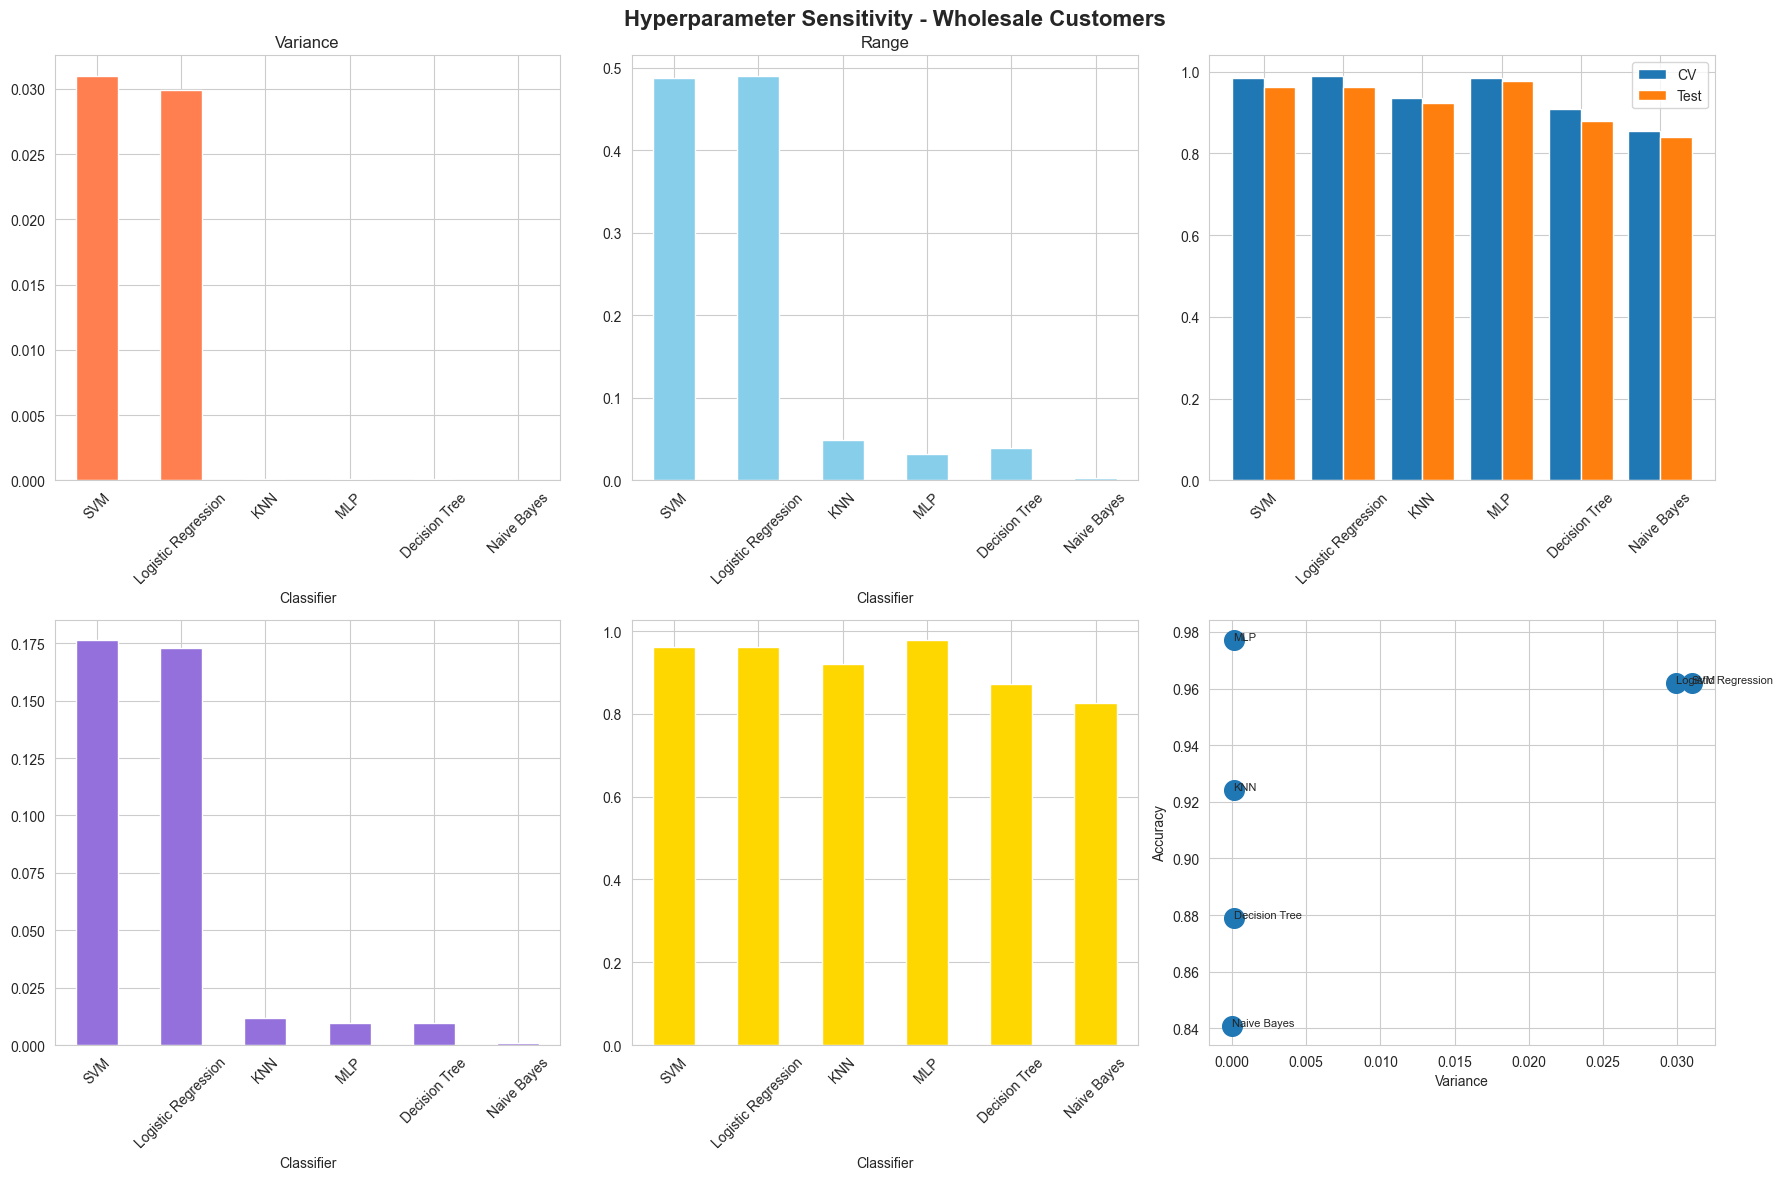


✓ Analysis complete for Wholesale Customers dataset


In [5]:
sensitivity_summary = pd.DataFrame({
    'Classifier': list(grid_results.keys()),
    'Best CV Score': [grid_results[n]['best_score'] for n in grid_results],
    'Test Accuracy': [grid_results[n]['test_accuracy'] for n in grid_results],
    'Test F1': [grid_results[n]['test_f1'] for n in grid_results],
    'Variance': [grid_results[n]['variance'] for n in grid_results],
    'Std Dev': [grid_results[n]['std'] for n in grid_results],
    'Range': [grid_results[n]['range'] for n in grid_results]
}).round(4).sort_values('Variance', ascending=False)

print("\nSENSITIVITY RANKING - WHOLESALE CUSTOMERS")
print("="*80)
print(sensitivity_summary.to_string(index=False))

sensitivity_summary.to_csv('outputs/results/wholesale_sensitivity.csv', index=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Sensitivity - Wholesale Customers', fontsize=16, fontweight='bold')

sensitivity_summary.plot(x='Classifier', y='Variance', kind='bar', ax=axes[0,0], color='coral', legend=False)
axes[0,0].set_title('Variance')
axes[0,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Range', kind='bar', ax=axes[0,1], color='skyblue', legend=False)
axes[0,1].set_title('Range')
axes[0,1].tick_params(axis='x', rotation=45)

x_pos = np.arange(len(sensitivity_summary))
axes[0,2].bar(x_pos - 0.2, sensitivity_summary['Best CV Score'], 0.4, label='CV')
axes[0,2].bar(x_pos + 0.2, sensitivity_summary['Test Accuracy'], 0.4, label='Test')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(sensitivity_summary['Classifier'], rotation=45)
axes[0,2].legend()

sensitivity_summary.plot(x='Classifier', y='Std Dev', kind='bar', ax=axes[1,0], color='mediumpurple', legend=False)
axes[1,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Test F1', kind='bar', ax=axes[1,1], color='gold', legend=False)
axes[1,1].tick_params(axis='x', rotation=45)

axes[1,2].scatter(sensitivity_summary['Variance'], sensitivity_summary['Test Accuracy'], s=200)
for _, row in sensitivity_summary.iterrows():
    axes[1,2].annotate(row['Classifier'], (row['Variance'], row['Test Accuracy']), fontsize=8)
axes[1,2].set_xlabel('Variance')
axes[1,2].set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('outputs/figures/wholesale_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analysis complete for Wholesale Customers dataset")
print("="*80)